In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterstats import zonal_stats
from rasterio.plot import show
import geopandas as gpd
import pandas as pd

# Set Path Variables

In [5]:
data_path_name = 'data/datacube_ROI/'
data_path = Path(data_path_name)
data_path.exists()

True

In [6]:
tif_paths = sorted(list(data_path.glob('*.tif')))
tif_paths

[PosixPath('data/datacube_ROI/UAVSAR_RTC_hh_20190620_rabarsar.tif'),
 PosixPath('data/datacube_ROI/UAVSAR_RTC_hv_20190620_rabarsar.tif'),
 PosixPath('data/datacube_ROI/UAVSAR_RTC_vv_20190620_rabarsar.tif'),
 PosixPath('data/datacube_ROI/hansen_3.tif'),
 PosixPath('data/datacube_ROI/hansen_4.tif'),
 PosixPath('data/datacube_ROI/hansen_5.tif'),
 PosixPath('data/datacube_ROI/hansen_7.tif')]

In [7]:
output_path_name = 'out'
out_path = Path(output_path_name)
out_path.mkdir(exist_ok=True, parents=True)

# Read the Superpixel Vector Data

In [8]:
superpixels_path = str(out_path/'superpixels')
superpixel_df = gpd.read_file(superpixels_path)
superpixel_df.head()

,label,geometry
0,3,"POLYGON ((-91.53514999999999 29.58175, -91.534..."
1,2,"POLYGON ((-91.53494999999999 29.58135, -91.534..."
2,3,"POLYGON ((-91.53484999999999 29.58135, -91.534..."
3,2,"POLYGON ((-91.53484999999999 29.58125, -91.534..."
4,2,"POLYGON ((-91.53474999999999 29.58115, -91.534..."


We will plot it, though the region of interest is so large that's its hard to get an idea of how well the segments are capturing the features. Better to open in QGIS.

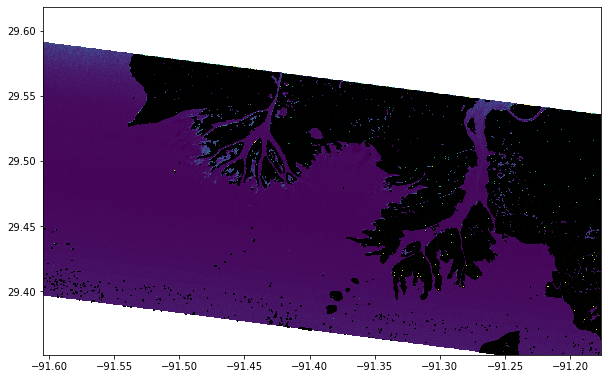

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
with rasterio.open(tif_paths[0]) as ds:
    show(ds, vmin=0, vmax=.5, ax=ax)
    superpixel_df.plot(ax=ax, column='label', edgecolor='black', facecolor=(0, 0, 0, 0))

In [10]:
%%time

zonal_stats_hh = zonal_stats(superpixel_df, tif_paths[0], stats=['std', 'mean'])
zonal_stats_hh = [{'mean_hh': data['mean'], 
                   'std_hh': data['std']} for data in zonal_stats_hh]
df_hh_superpixels = pd.DataFrame(zonal_stats_hh)

CPU times: user 1min 52s, sys: 8.06 s, total: 2min
Wall time: 2min


In [11]:
%%time

zonal_stats_hv = zonal_stats(superpixel_df, tif_paths[1], stats=['std', 'mean'])
zonal_stats_hv = [{'mean_hv': data['mean'],
                   'std_hv': data['std']} for data in zonal_stats_hv]
df_hv_superpixels = pd.DataFrame(zonal_stats_hv)

CPU times: user 1min 52s, sys: 8.14 s, total: 2min
Wall time: 2min


In [14]:
%%time

zonal_stats_vv = zonal_stats(superpixel_df, tif_paths[2], stats=['std', 'mean'])
zonal_stats_vv = [{'mean_vv': data['mean'],
                   'std_vv': data['std']} for data in zonal_stats_vv]
df_vv_superpixels = pd.DataFrame(zonal_stats_vv)

CPU times: user 1min 53s, sys: 8.1 s, total: 2min 2s
Wall time: 2min 2s


In [14]:
%%time

zonal_stats_srtm = zonal_stats(superpixel_df, tif_paths[1], stats=['std', 'mean'])
zonal_stats_srtm = [{'mean_srtm': data['mean'],
                     'std_srtm': data['mean']} for data in zonal_stats_srtm]
df_srtm_superpixels = pd.DataFrame(zonal_stats_srtm)

CPU times: user 5min 6s, sys: 17 s, total: 5min 23s
Wall time: 5min 23s


## Combining Zonal Stats into Superpixel GeoDataframe

In [15]:
superpixel_analysis_df = pd.concat([superpixel_df,
                                    df_hh_superpixels,
                                    df_hv_superpixels,
                                    df_srtm_superpixels], axis=1)
superpixel_analysis_df.head()

,label,geometry,mean_hh,std_hh,mean_hv,std_hv,mean_srtm,std_srtm
0,6,POLYGON ((-91.54012829336666 29.68416618793971...,0.031622,0.000000,0.004705,0.000000,0.004705,0.004705
1,6,POLYGON ((-91.54002364527399 29.68398830181912...,0.024796,0.000000,0.005643,0.000000,0.005643,0.005643
2,6,POLYGON ((-91.53991899718133 29.68389935875883...,0.022128,0.000000,0.005497,0.000000,0.005497,0.005497
3,2,"POLYGON ((-91.54222125522 29.684255131, -91.54...",0.019109,0.005382,0.003029,0.001197,0.003029,0.003029
4,9,POLYGON ((-91.53615166584532 29.68416618793971...,0.212458,0.067007,0.018045,0.008324,0.018045,0.018045


## Adding `db` column 

In [16]:
superpixel_analysis_df['mean_hh_db'] = superpixel_analysis_df['mean_hh'].map(lambda val: 10 * np.log10(val))
superpixel_analysis_df['mean_hv_db'] = superpixel_analysis_df['mean_hv'].map(lambda val: 10 * np.log10(val))
superpixel_analysis_df.head()

,label,geometry,mean_hh,std_hh,mean_hv,std_hv,mean_srtm,std_srtm,mean_hh_db,mean_hv_db
0,6,POLYGON ((-91.54012829336666 29.68416618793971...,0.031622,0.000000,0.004705,0.000000,0.004705,0.004705,-15.000064,-23.274741
1,6,POLYGON ((-91.54002364527399 29.68398830181912...,0.024796,0.000000,0.005643,0.000000,0.005643,0.005643,-16.056130,-22.484689
2,6,POLYGON ((-91.53991899718133 29.68389935875883...,0.022128,0.000000,0.005497,0.000000,0.005497,0.005497,-16.550614,-22.598369
3,2,"POLYGON ((-91.54222125522 29.684255131, -91.54...",0.019109,0.005382,0.003029,0.001197,0.003029,0.003029,-17.187515,-25.187247
4,9,POLYGON ((-91.53615166584532 29.68416618793971...,0.212458,0.067007,0.018045,0.008324,0.018045,0.018045,-6.727275,-17.436427


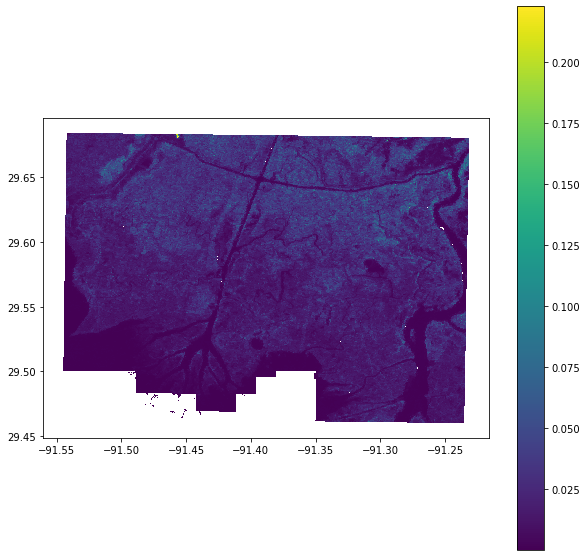

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
superpixel_analysis_df.plot(ax=ax, column='mean_hv', legend=True)

We save our new geodataframe as a shapefile (or GeoJSON). However, it will take some time to write with so many columns.

In [19]:
superpixel_analysis_df.to_file(out_path/'superpixels_with_attributes')

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
